# SARIMA forecast

## 01 - Background

Our goal in this challenge is to apply the basic concepts of time series analysis on one-dimension data (sales depending on the date).

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;
3. use an econometric approach to model the serie and be able to forecast it;
4. use machine learning to hack this modelization.

The dataset is the csv

## 02 - Load Data and Plot Time Series
Let's start by loading the time series of the challenge and plot the time series

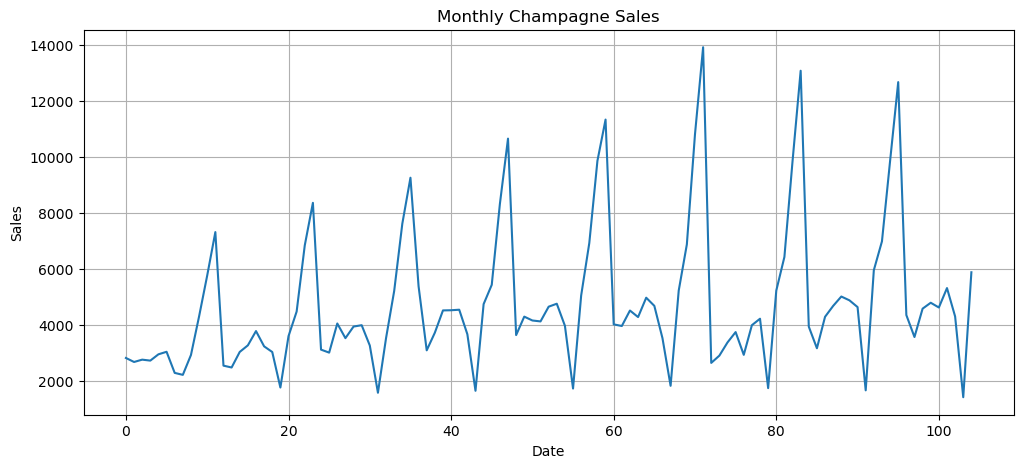

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Load the data with proper parsing, skipping the header row
df = pd.read_csv('monthly_champagne_sales.csv', names=['Month', 'Sales'], skiprows=1)

# Plot the time series
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Sales'])
plt.title('Monthly Champagne Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

👉 Convert dataframe with datetime objects as index to make it look like this
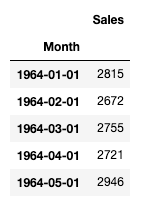

In [56]:
# Convert Month column to datetime and set as index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

print(df.head(5))

            Sales
Month            
1964-01-01   2815
1964-02-01   2672
1964-03-01   2755
1964-04-01   2721
1964-05-01   2946


## 04 - Visualize and interpet the data

Well done, thanks to this "reindexing", you should now be able to plot the "Sales" (y-axis) as a function of the time (x-axis) easily

<Axes: xlabel='Month'>

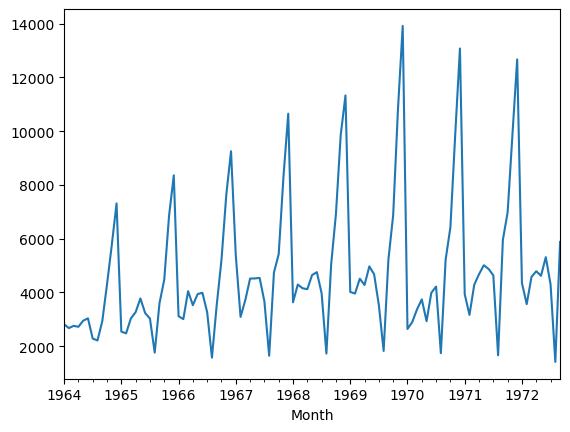

In [57]:
df['Sales'].plot()


If your code is correct, you should be able to see that this Time Serie (TS) is:
- Not stationary (mean and variance are not constant).
- Exhibits strong seasonality.
- Seems to have a trend.

Let's see a decomposition of the data between **trend**, **saisonality** and **noise**. In order to do that, you have to make use of statsmodels [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html). Read the docs and make sure you understand what this function is doing and how to use it. Then:
1. plot the "Sales" with an "additive" model
2. plot the "Sales" with a "multiplicative" model

Pro tips: end your statsmodels plot method calls with a `;` to avoid double-plotting issues

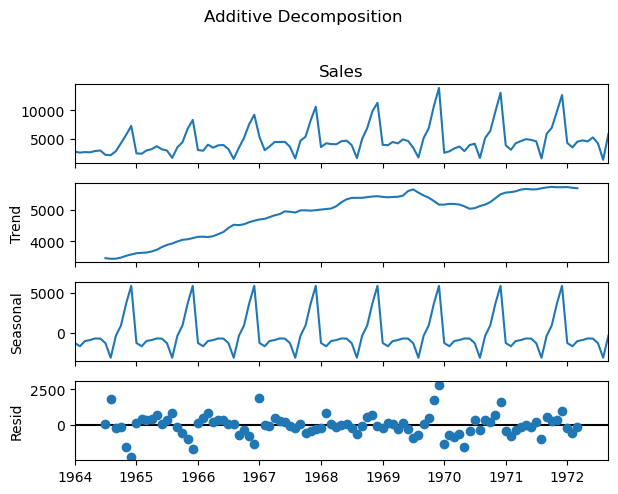

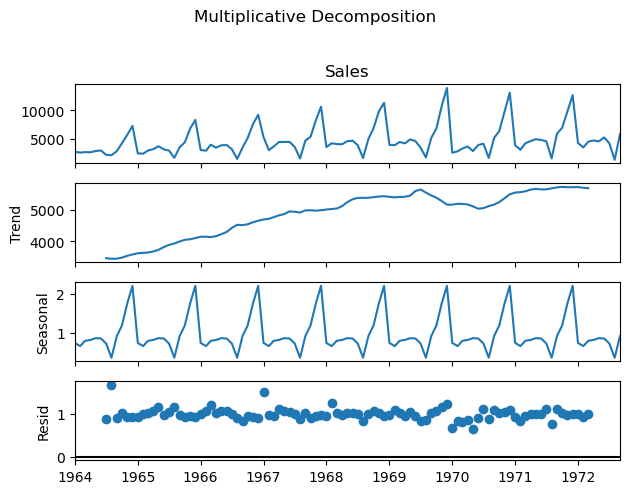

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Additive model
result_add = seasonal_decompose(df["Sales"], model="additive", period=12)
result_add.plot();
plt.suptitle("Additive Decomposition", y=1.02)
plt.tight_layout()

# Multiplicative model
result_mul = seasonal_decompose(df["Sales"], model="multiplicative", period=12)
result_mul.plot();
plt.suptitle("Multiplicative Decomposition", y=1.02)
plt.tight_layout()


👉 De-seasonalize this time serie using the decomposition of your choice

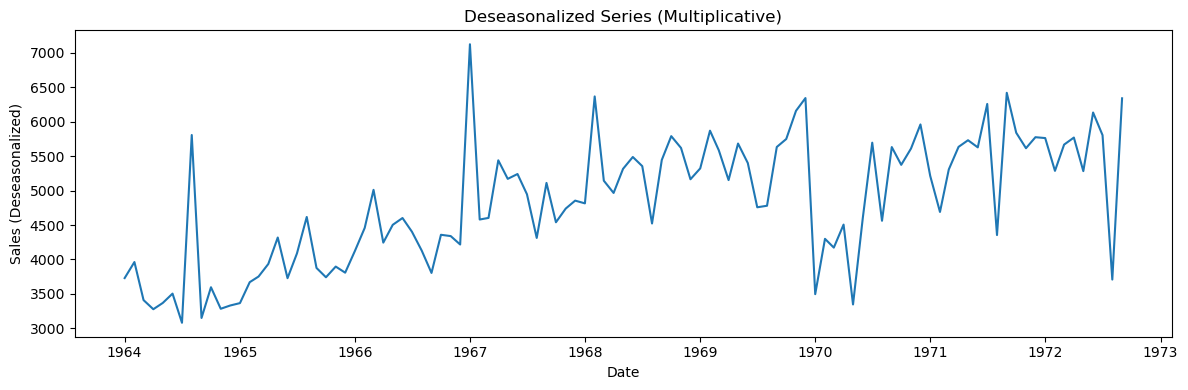

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Décomposer avec modèle multiplicatif
result_mul = seasonal_decompose(df["Sales"], model="multiplicative", period=12)

# Désaisonnalisation : Observé / Saison
deseasonalized = df["Sales"] / result_mul.seasonal
deseasonalized = deseasonalized.dropna()

# Afficher la série désaisonnalisée
plt.figure(figsize=(12, 4))
plt.plot(deseasonalized)
plt.title("Deseasonalized Series (Multiplicative)")
plt.xlabel("Date")
plt.ylabel("Sales (Deseasonalized)")
plt.tight_layout()
plt.show()


☝️ We could fit an ARIMA model on a "de-seasonalized" version of this time serie, and then re-compose it back after our forecast. But in this challenge, we will use SARIMA models to _directly_ fit the original time serie!

## 05 - Split the data (train/test)


For time series, we cannot randomly sample points to be in the test set. The test set needs to be "out-of-time", that is, strictly in the future of the test set. For the purpose of this exercise, we will use data up to 1970 for training and after for the test.

👉 create `df_train` and `df_test`, splitting the DataFrame before 1970 for the training and after (or equal to) for the testing

In [60]:
# Split train/test datasets based on time
df_train = df[df.index < "1970-01-01"]
df_test = df[df.index >= "1970-01-01"]

# Optionally display their shapes or ranges
print("Train set:", df_train.index.min(), "→", df_train.index.max(), f"({len(df_train)} points)")
print("Test set :", df_test.index.min(), "→", df_test.index.max(), f"({len(df_test)} points)")


Train set: 1964-01-01 00:00:00 → 1969-12-01 00:00:00 (72 points)
Test set : 1970-01-01 00:00:00 → 1972-09-01 00:00:00 (33 points)


## 06 - SARIMA
We will analyse the data using a SARIMA model (Seasonal Auto Regressive Integrated Moving Average).


We need to :
- find how to stationarize the time serie (I in SARIMA)
- find the auto-regressive (AR) part
- find the Moving-Average (MA) part
- find the seasonality (S)

### Step 1: Check stationarity

If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast.

A quick glance at the plot above should be sufficient to convince you that the time serie is not stationary.

Double check the stationarity of `df["Sales"]` using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) and especially its p-value

In [61]:
from statsmodels.tsa.stattools import adfuller

# Appliquer le test ADF
adf_result = adfuller(df["Sales"])

# Afficher le p-value
print(f"ADF p-value: {adf_result[1]:.4f}")

# Conclusion rapide
if adf_result[1] < 0.05:
    print("✅ La série est stationnaire (p < 0.05)")
else:
    print("❌ La série n'est pas stationnaire (p >= 0.05)")


ADF p-value: 0.3639
❌ La série n'est pas stationnaire (p >= 0.05)


The p-value should be less than 0.05 to have a 95% confidence in the stationarity.  

If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

Ideally, p is *much* smaller than 0.05.

Another way to look for stationarity, is to look at the autocorrelation function (ACF).

Plot the ACF of the time series. You should see a large peak at lag 12, indicating strong yearly seasonality.

<Figure size 1000x400 with 0 Axes>

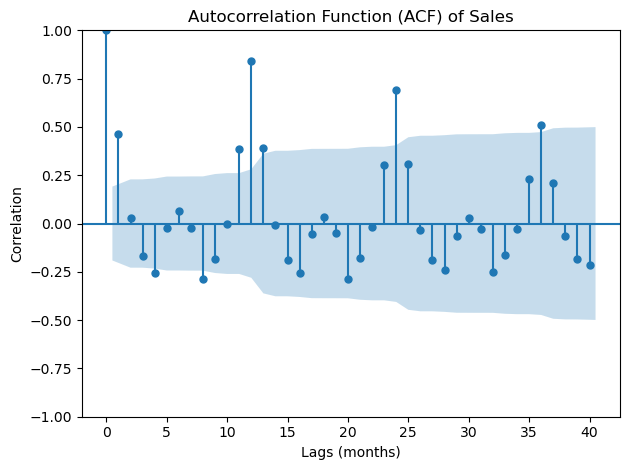

In [62]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Tracer l'ACF
plt.figure(figsize=(10, 4))
plot_acf(df["Sales"], lags=40)
plt.title("Autocorrelation Function (ACF) of Sales")
plt.xlabel("Lags (months)")
plt.ylabel("Correlation")
plt.tight_layout()
plt.show()


### Step 2 - Seasonal differencing (D)

We have a strong seasonality with a period of 12 months.

Do a **seasonal differencing of lag 12** on the time series, and plot the differenced data and check the ACF plot (+ADF test) again.

Don't forget to drop NaN's.

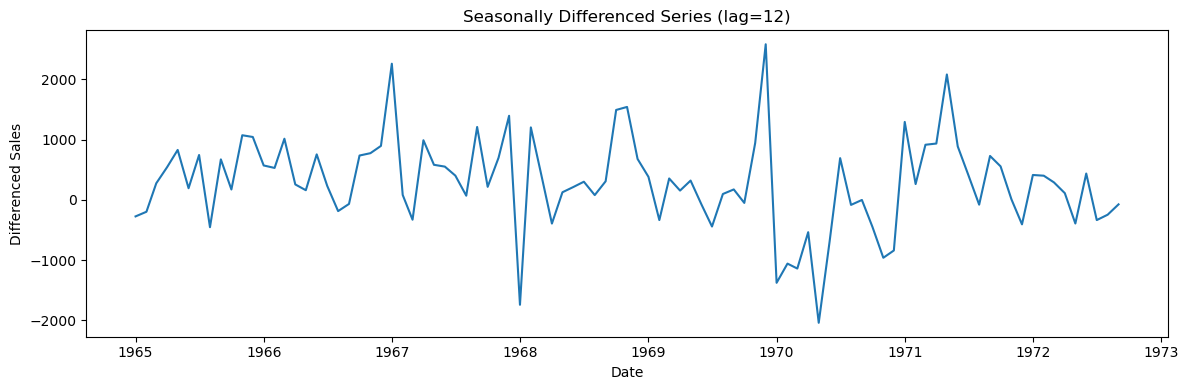

<Figure size 1000x400 with 0 Axes>

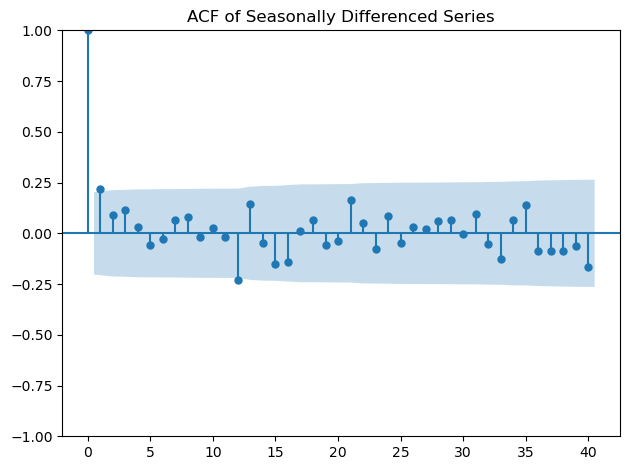

ADF p-value after seasonal differencing: 0.0000
✅ Série désormais stationnaire (p < 0.05)


In [63]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Seasonal differencing (lag=12)
df_seasonal_diff = df["Sales"].diff(12).dropna()

# Tracer la série différenciée
plt.figure(figsize=(12, 4))
plt.plot(df_seasonal_diff)
plt.title("Seasonally Differenced Series (lag=12)")
plt.xlabel("Date")
plt.ylabel("Differenced Sales")
plt.tight_layout()
plt.show()

# Tracer l'ACF
plt.figure(figsize=(10, 4))
plot_acf(df_seasonal_diff, lags=40)
plt.title("ACF of Seasonally Differenced Series")
plt.tight_layout()
plt.show()

# Test ADF
adf_result = adfuller(df_seasonal_diff)
pval = adf_result[1]
print(f"ADF p-value after seasonal differencing: {pval:.4f}")

if pval < 0.05:
    print("✅ Série désormais stationnaire (p < 0.05)")
else:
    print("❌ Série toujours non stationnaire (p >= 0.05)")


☝️ One single seasonal differencing seems enough to stationarize the TS.  
D=1 (1 seasonal diff) and m=12 (seasonality = 12) for SARIMA(p,d,q, P,D,Q,m)

### Step 3 - Differencing (d)

If the time series is still not stationary, it needs to be stationarized through *differencing*. It means that we take the difference between each value and the preceding one (*first difference*).

Do we need further differencing after removing the seasonality?

Check the ACF and ADF after running an additional first order diff(1) on your diff(12) series.

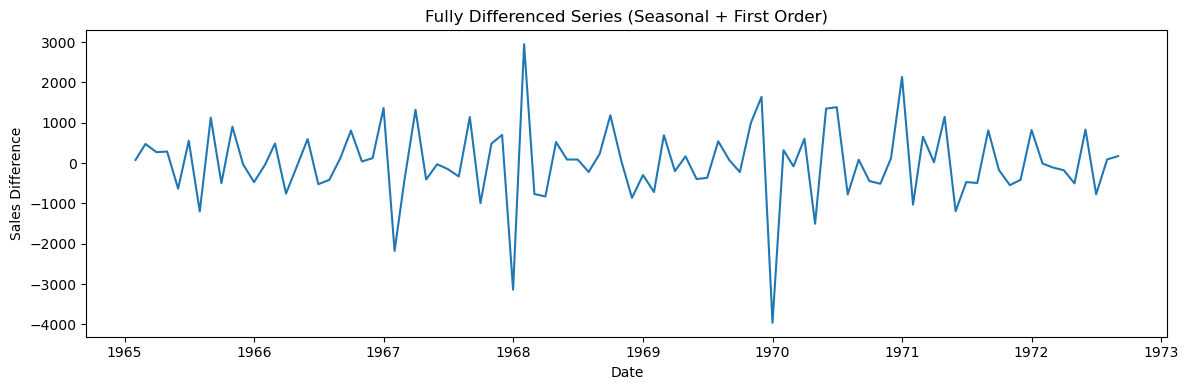

<Figure size 1000x400 with 0 Axes>

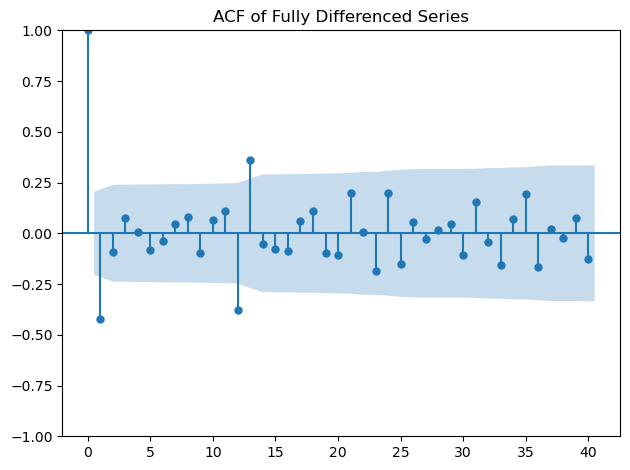

ADF p-value after full differencing: 0.0003
✅ Série stationnaire après diff(12) + diff(1)


In [64]:
# Première différenciation sur la série déjà saisonnièrement différenciée
df_diff_full = df_seasonal_diff.diff().dropna()

# Tracer la série entièrement différenciée
plt.figure(figsize=(12, 4))
plt.plot(df_diff_full)
plt.title("Fully Differenced Series (Seasonal + First Order)")
plt.xlabel("Date")
plt.ylabel("Sales Difference")
plt.tight_layout()
plt.show()

# Tracer l'ACF de la série complètement différenciée
plt.figure(figsize=(10, 4))
plot_acf(df_diff_full, lags=40)
plt.title("ACF of Fully Differenced Series")
plt.tight_layout()
plt.show()

# Test ADF
adf_result = adfuller(df_diff_full)
pval = adf_result[1]
print(f"ADF p-value after full differencing: {pval:.4f}")

if pval < 0.05:
    print("✅ Série stationnaire après diff(12) + diff(1)")
else:
    print("❌ Série toujours non stationnaire")


👉 Additional differencing actually made both the p-value and the ACF look worse! 
We can select (d=0) and (D=1)

### Step 4 - Select AR(p,P) and MA(q,Q) terms

You will now use the ACF and PACF plots to decide whether to include an AR term(s), MA term(s), or both.





- The autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to your **fully differentiated** series allows you to select MA number (`q`)
- MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d+D)}}$ cuts off


- The partial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to your **fully differentiated** series allows you to select AR (`p`)
- AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d+D)}}$  cuts off

<Figure size 1000x400 with 0 Axes>

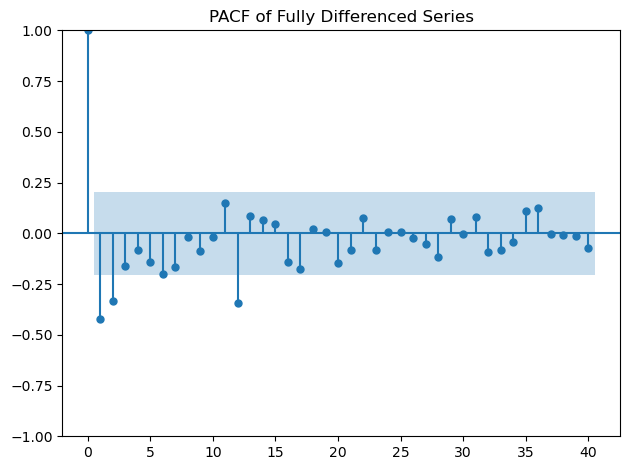

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -627.562
Date:                            Fri, 06 Jun 2025   AIC                           1265.123
Time:                                    15:53:55   BIC                           1276.907
Sample:                                01-01-1964   HQIC                          1269.840
                                     - 09-01-1972                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2540      0.085      2.987      0.003       0.087       0.421
ma.L1         -0.9526      0.054   

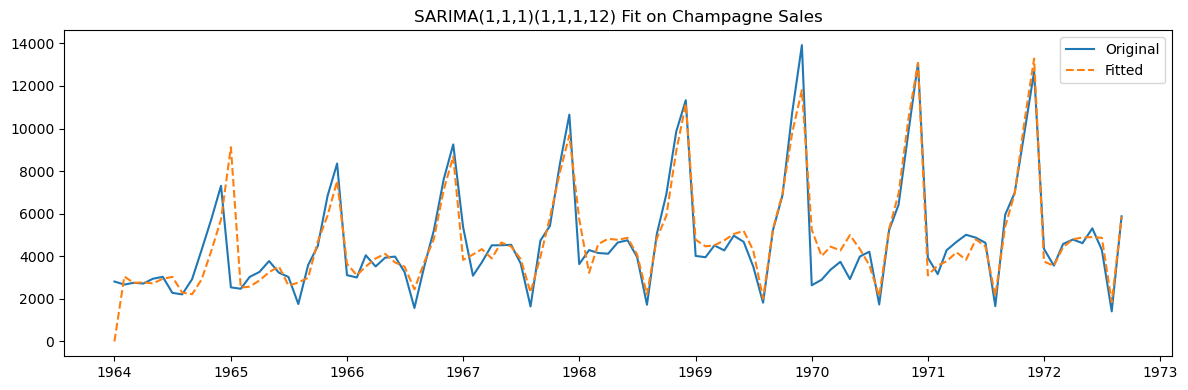

In [65]:
from statsmodels.graphics.tsaplots import plot_pacf

# Tracer le PACF de la série complètement différenciée
plt.figure(figsize=(10, 4))
plot_pacf(df_diff_full, lags=40)
plt.title("PACF of Fully Differenced Series")
plt.tight_layout()
plt.show()

#Based on ACF and PACF, we can see that the series is stationary and the best model should be ARIMA(1,1,1)

from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Création et entraînement du modèle SARIMA
model = SARIMAX(
    df['Sales'],
    order=(1, 1, 1),         # (p, d, q)
    seasonal_order=(1, 1, 1, 12),  # (P, D, Q, s)
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)

# Affichage du résumé
print(results.summary())

# Visualisation de l'ajustement in-sample
df['fitted'] = results.fittedvalues

plt.figure(figsize=(12, 4))
plt.plot(df['Sales'], label='Original')
plt.plot(df['fitted'], label='Fitted', linestyle='--')
plt.title('SARIMA(1,1,1)(1,1,1,12) Fit on Champagne Sales')
plt.legend()
plt.tight_layout()
plt.show()


☝️ It seems like there are no significant peaks in either ACF or PACF, so most likely p=q=0.  
Our first guess for SARIMA is therefore d=0, p=q=0, D=1 and m=12.  

How to find values for P and Q? Here, we will let pdarima try values 1 and 0 for P and Q with a grid_search for us.
If you really want to find these coefficient by yourself, [Read here 🤯 ](https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima) for some rules of thumb

👉 Run [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) for the training set. set seasonal=True, m=12 and D=1. Search for p and q, P and Q from 0 to 2. Then, print the summary of the model with model.summary().
Use `njobs=-1, trace=True, error_action='ignore', suppress_warnings=True`

In [66]:
from pmdarima import auto_arima

# Extraire les données d'entraînement (si pas déjà fait)
df_train = df[df.index < "1970-01-01"]

# Lancer la recherche de modèle optimal avec auto_arima
model = auto_arima(
    df_train["Sales"],
    seasonal=True,
    m=12,              # saisonnalité annuelle
    d=1,               # différenciation non-saisonnière
    D=1,               # différenciation saisonnière
    max_p=2, max_q=2,  # recherche p et q entre 0 et 2
    max_P=2, max_Q=2,  # recherche P et Q entre 0 et 2
    trace=True,        # affiche les essais en console
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_jobs=-1          # parallélisation maximale
)

# Afficher le résumé du meilleur modèle trouvé
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=0.78 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=971.186, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=960.946, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=962.899, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=962.511, Time=0.41 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=963.166, Time=0.14 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=961.809, Time=0.14 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.96 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=966.791, Time=0.06 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=957.815, Time=0.06 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=957.181, Time=0.02 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=958.192, Time=0.09 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=959.555, Time=0.16 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=in

The best model found is `ARIMA(0,0,0)(0,1,0)[12]` ! 
This means that the Time Serie condidered does not justify adding any "autoregressive" nor "moving average" modelling beyond simple "seasonal differencing".

Such "poor" model is only likely to predict a repetition of the last seasonal pattern detected, alongwith the prolongation of the mean increasing trend. Let's check it out

👉 Use `model.predict` with `n_periods` = length of the test set, in order to save the following three predictions
- `central`
- `upper`
- `lower`

Save them as Pandas Series, and index them by the same index than your `y_test`

In [67]:
# Assure-toi que df_test est défini
y_test = df[df.index >= "1970-01-01"]["Sales"]

# Prédictions pour la période de test
n_periods = len(y_test)
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

# Créer les séries pandas pour les prédictions
central = pd.Series(forecast, index=y_test.index)
lower = pd.Series(conf_int[:, 0], index=y_test.index)
upper = pd.Series(conf_int[:, 1], index=y_test.index)

# Affichage rapide
print("Central forecast:\n", central.head())
print("\nConfidence Interval:")
print("Lower:\n", lower.head())
print("Upper:\n", upper.head())


Central forecast:
 Month
1970-01-01    5390.675092
1970-02-01    5443.993694
1970-03-01    6334.587197
1970-04-01    5881.865776
1970-05-01    6580.604678
dtype: float64

Confidence Interval:
Lower:
 Month
1970-01-01    3921.461652
1970-02-01    3825.843075
1970-03-01    4601.416025
1970-04-01    3923.446937
1970-05-01    4474.782409
dtype: float64
Upper:
 Month
1970-01-01    6859.888532
1970-02-01    7062.144313
1970-03-01    8067.758368
1970-04-01    7840.284615
1970-05-01    8686.426946
dtype: float64


👇 Run the cell below to plot your predictions against reality

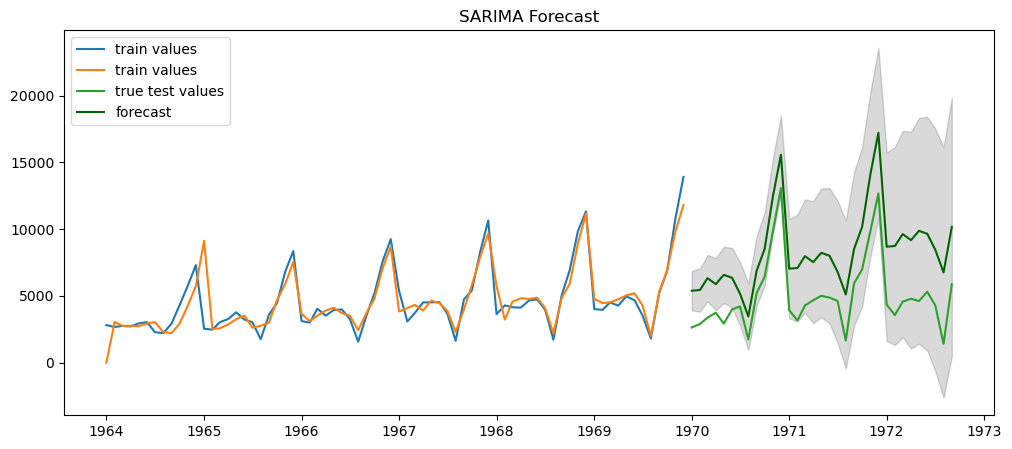

In [68]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label = "train values")
plt.plot(df_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

👉 Try to assign non-null values to  `p`,`d`,`P`,`D` on your SARIMA and re-plot this chart to compare effects!

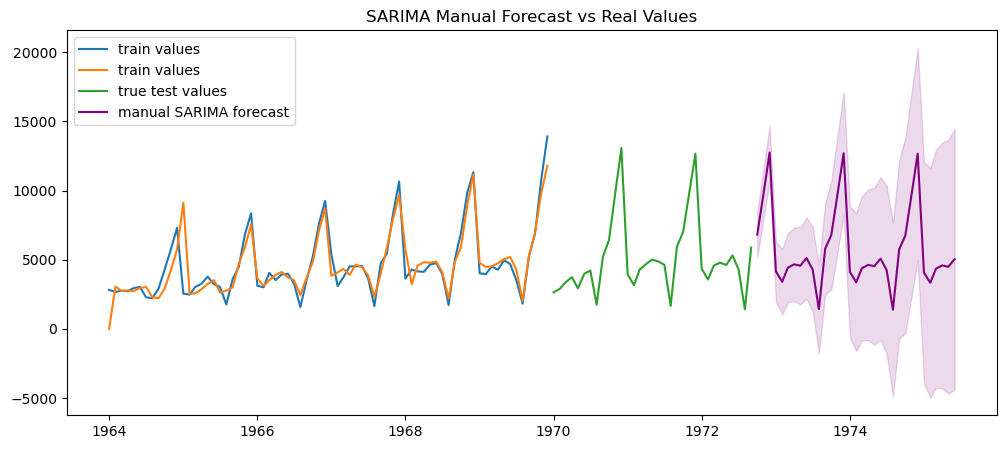

In [69]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Choix manuel d'autres paramètres (exemple : plus simple)
manual_model = SARIMAX(
    df["Sales"],
    order=(2, 1, 0),              # (p, d, q)
    seasonal_order=(0, 1, 1, 12), # (P, D, Q, m)
    enforce_stationarity=False,
    enforce_invertibility=False
)

manual_results = manual_model.fit(disp=False)

# Prédictions hors échantillon
forecast_manual = manual_results.get_forecast(steps=len(df_test))
central_manual = forecast_manual.predicted_mean
conf_int_manual = forecast_manual.conf_int()
lower_manual = conf_int_manual.iloc[:, 0]
upper_manual = conf_int_manual.iloc[:, 1]

# Re-plot pour comparer
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label="train values")
plt.plot(df_test, label="true test values")
plt.plot(central_manual, color='purple', label="manual SARIMA forecast")
plt.fill_between(lower_manual.index,
                 lower_manual,
                 upper_manual,
                 color='purple', alpha=.15)

plt.title("SARIMA Manual Forecast vs Real Values")
plt.legend()
plt.show()


# Machine Learning Approach

### Model with forecast horizon = 1 month only

We will now fit a non linear model such as a random forest. The idea is to predict a value from the last ones. 

👉 Create new columns in `df` that are shifted version of `df['Sales']`. Do it with a shift from 1 to 12.

In [70]:
# Add lagged values
# Créer des colonnes de lags de 1 à 12 mois
for lag in range(1, 13):
    df[f'lag_{lag}'] = df['Sales'].shift(lag)

# Aperçu du résultat
df.tail(15)

# Drop nan
df = df.dropna()

# Créer X_train, y_train
X_train = df_train.drop(columns=['Sales'])
y_train = df_train['Sales']

# Créer X_test, y_test
X_test = df_test.drop(columns=['Sales'])
y_test = df_test['Sales']

# Sauvegarder les index du jeu de test



In [71]:
# Keep track of test_indexes
test_indexes = X_test.index


In [72]:
# Create X, y
X = df.drop(columns=['Sales'])
y = df['Sales']


👉 Instanciate (don't train) a `random forest` algorithm to predict Sales based in your shifted features

In [73]:
from sklearn.ensemble import RandomForestRegressor

# Instancier le modèle (ne pas encore fit)
random_forest = RandomForestRegressor(
    n_estimators=100,   # nombre d'arbres
    max_depth=None,     # profondeur max (None = jusqu'à pureté)
    random_state=42     # pour reproductibilité
)


👉 You can use the following function to test it. It takes the true y values (`data` which should be a Numpy array), the indexes of the test samples (`test_indexes`), the predictor (`predictor`: your random forest algorithm) and the shifted columns (`full_X` which should be a Numpy array).

In [74]:
# For each predictor, design a method to evaluate its performance on the test set:
from sklearn.metrics import r2_score
def evaluate_performance_month_prediction(y_true, test_indexes, predictor, full_X):
    predictions = []
    ground_truth = []

    for _indx in test_indexes:
        t = y_true.index.get_loc(_indx)
        train_data = y_true.iloc[:t]
        train_features = full_X.iloc[:t]

        current_ground_truth = y_true.iloc[t]
        current_ground_truth_features = X.iloc[t]
        # Fit the model up to time t-1
        predictor.fit(train_features, train_data)
        prediction = predictor.predict(current_ground_truth_features.values.reshape(1, -1))[0]

        predictions.append(prediction)
        ground_truth.append(current_ground_truth)

    # MAPE calculation
    ground_truth = np.array(ground_truth)
    predictions = np.array(predictions)
    mape = np.mean(np.abs(predictions - ground_truth) / np.abs(ground_truth))

    return ground_truth, predictions, mape

In [75]:
results = evaluate_performance_month_prediction(
    y_true=y,
    test_indexes=test_indexes,
    predictor=rf_model,
    full_X=X
)

print(f"MAPE: {mape:.2%}")

MAPE: 20.25%


In [76]:
print('Mean Absolute Prediction Error MAPE')
results[2]

Mean Absolute Prediction Error MAPE


0.1547279353816383

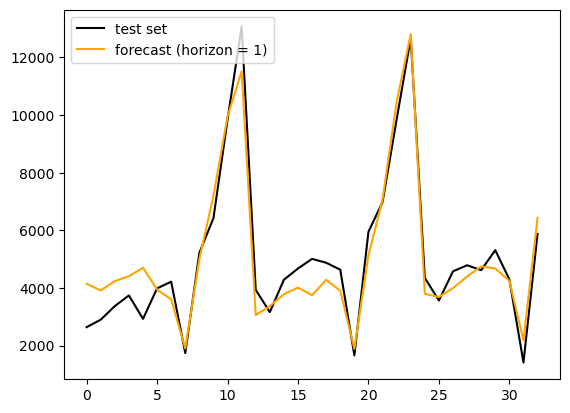

In [77]:
plt.plot(results[0], c='black', label='test set')
plt.plot(results[1], c='orange', label='forecast (horizon = 1)')
plt.legend()

To improve our model, we can do some feature engineering. You will add moving averages to the data used to train the random forest.

Try to create 3 new columnns in `df`: one which is the rolling average of `df[Sales]` with a window of 12, one with a window of 3, and one with a window of 2. This will have the effect to isolate the trend and allow the algorithm to learn it. Also, plot these data.


You can also add a more smoothing predictor using the exponential moving average (hint: method `.ewm` with `halflife` of 2, 3 and 12), that statistically optimizes an AR process. Plot also the data.

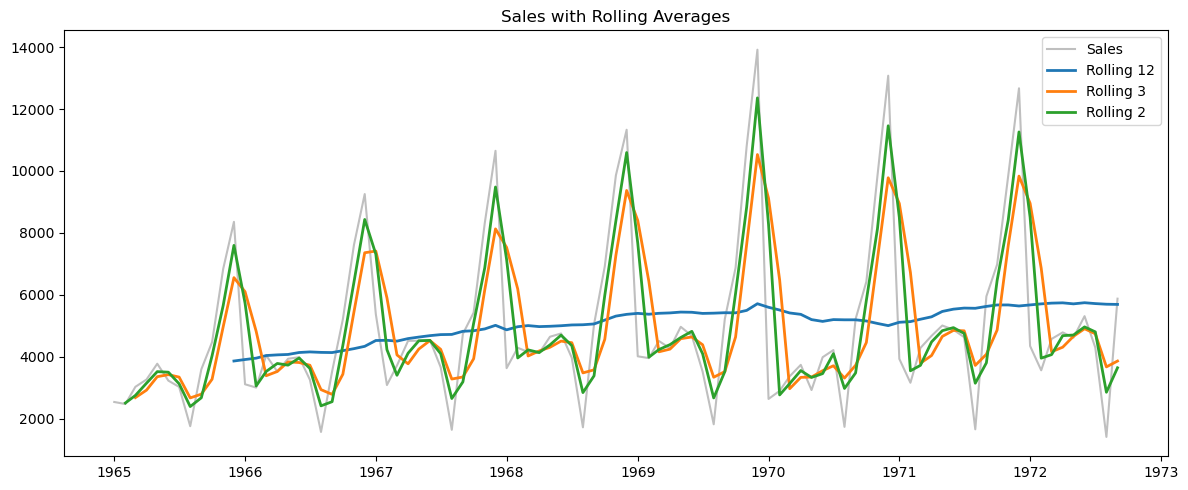

In [79]:
# Création des moyennes mobiles
df["rolling_12"] = df["Sales"].rolling(window=12).mean()
df["rolling_3"] = df["Sales"].rolling(window=3).mean()
df["rolling_2"] = df["Sales"].rolling(window=2).mean()
# Plot des ventes + moyennes mobiles
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df["Sales"], label="Sales", color="gray", alpha=0.5)
plt.plot(df["rolling_12"], label="Rolling 12", linewidth=2)
plt.plot(df["rolling_3"], label="Rolling 3", linewidth=2)
plt.plot(df["rolling_2"], label="Rolling 2", linewidth=2)

plt.title("Sales with Rolling Averages")
plt.legend()
plt.tight_layout()
plt.show()



You should see a better MAPE!

In [80]:
# 2. Supprimer les lignes avec NaN (générées par les rolling et lags)
df = df.dropna()

# 3. Recréer X et y
X = df.drop(columns=["Sales"])
y = df["Sales"]

# 4. Split temporel train/test
df_train = df[df.index < "1970-01-01"]
df_test = df[df.index >= "1970-01-01"]

X_train = df_train.drop(columns=["Sales"])
y_train = df_train["Sales"]
X_test = df_test.drop(columns=["Sales"])
y_test = df_test["Sales"]

# Sauvegarder les index pour évaluation
test_indexes = X_test.index

# 5. Ré-instancier le modèle
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42
)

# 6. Ré-évaluation avec les nouvelles features
ground_truth, predictions, mape = evaluate_performance_month_prediction(
    y_true=y,
    test_indexes=test_indexes,
    predictor=random_forest,
    full_X=X
)

# 7. Affichage du MAPE
print("Mean Absolute Prediction Error (MAPE) with Rolling Averages:")
print(f"{mape:.2%}")



Mean Absolute Prediction Error (MAPE) with Rolling Averages:
15.74%


Try to look at the importance of each feature. What do you find?


In [81]:
# 1. Entraîner le modèle une seule fois sur tout l'entraînement
random_forest.fit(X_train, y_train)

# 2. Récupérer l'importance des features
importances = random_forest.feature_importances_
feature_names = X_train.columns

# 3. Affichage trié
import pandas as pd

feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(feature_importance_df)


       Feature  Importance
12      lag_12    0.459682
0       fitted    0.374925
15   rolling_2    0.061458
14   rolling_3    0.016343
11      lag_11    0.016024
2        lag_2    0.013443
1        lag_1    0.008404
6        lag_6    0.008270
13  rolling_12    0.007411
5        lag_5    0.006798
10      lag_10    0.005385
7        lag_7    0.005098
8        lag_8    0.004988
9        lag_9    0.004786
3        lag_3    0.004586
4        lag_4    0.002399


### Out-of-sample forecast models

Let's now try to beat SARIMA in the "out-of-sample" prediction. 

👉 Train _one model per horizon of forecast_ (from `1` month horizon to `len(y_test)` months)  
👉 Evaluate MAPE and compare with SARIMA

In [82]:
def evaluate_random_forest_by_horizon(X, y, test_indexes, base_model):
    predictions = []
    ground_truth = []

    for horizon, _indx in enumerate(test_indexes, start=1):
        # Index temporel en entier
        if _indx not in y.index or _indx not in X.index:
            continue

        t = y.index.get_loc(_indx)

        # Limiter l'entraînement à t - horizon
        train_data = y.iloc[:t - horizon + 1]
        train_features = X.iloc[:t - horizon + 1]

        # Exemple à prédire
        current_ground_truth = y.iloc[t]
        current_ground_truth_features = X.iloc[t]

        # Skip si NaN
        if train_data.isnull().any() or train_features.isnull().any().any():
            continue

        # Nouveau modèle pour chaque horizon
        model = base_model.__class__(**base_model.get_params())
        model.fit(train_features, train_data)

        prediction = model.predict(current_ground_truth_features.values.reshape(1, -1))[0]
        predictions.append(prediction)
        ground_truth.append(current_ground_truth)

    # MAPE
    predictions = np.array(predictions)
    ground_truth = np.array(ground_truth)
    mape = np.mean(np.abs(predictions - ground_truth) / np.abs(ground_truth))

    return ground_truth, predictions, mape

# Réutiliser le modèle de base
from sklearn.ensemble import RandomForestRegressor

base_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42
)

ground_truth_rf, predictions_rf, mape_rf = evaluate_random_forest_by_horizon(
    X=X,
    y=y,
    test_indexes=test_indexes,
    base_model=base_model
)

print(f"MAPE - Random Forest (one model per horizon): {mape_rf:.2%}")


MAPE - Random Forest (one model per horizon): 16.49%
